<a href="https://colab.research.google.com/github/Zarif-SBU/reinforcement_Learning/blob/main/monte_carlo_and_q-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo and Q-Learning
The goal of this assignment is to implement the RL algorithms listed as follows:
1. <b>Monte-Carlo</b> with a **tabular** state action value function
2. <b>Q-learning</b> with a **tabular** state action value function

2 Gymnasium environments are used (Cartpole-v1 and MountainCar-v0). As the behavior policy of off-policy RL methods, we used epsilon-greedy.


In [1]:
!pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.9 MB/s eta 0:00:00


In [2]:
import imageio
from IPython.display import Image, display
from io import BytesIO

# Code for visualizing the episode

class GIFMaker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.buffer = BytesIO()

    def append(self, img):
        self.images.append(img)

    def display(self):
        imageio.mimsave(self.buffer, self.images, format='gif')
        gif = Image(data=self.buffer.getvalue())
        display(gif)
        return gif

    def __len__(self):
      return len(self.images)

## Env1 CartPole-v1
Detailed information of this environment:
https://gymnasium.farama.org/environments/classic_control/cart_pole/

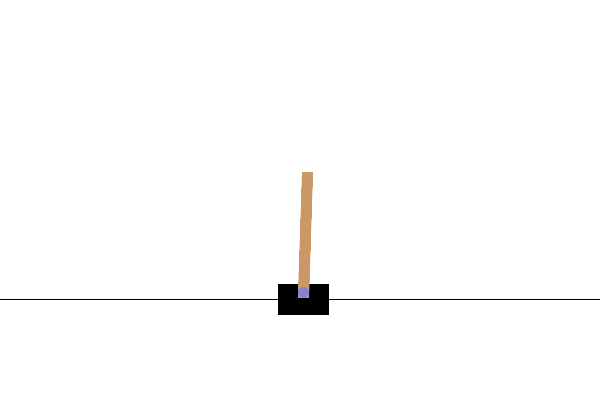

In [3]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode="rgb_array")
g = GIFMaker() # visualization
observation, info = env.reset(seed=42)
for i in range(500):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render()) # save one frame
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display() # show GIF animation
env.close()

## Env2 MountainCar-v0
Detailed information of this environment: https://gymnasium.farama.org/environments/classic_control/mountain_car/

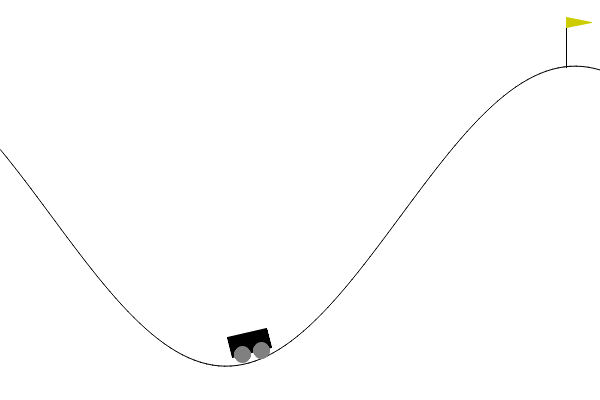

In [4]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

observation, info = env.reset(seed=42)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render())
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

## Discretization
These environments are originally with continuous state spaces. We discretized them so that we could apply (tabluar) MC and Q-Learning to them.

**CartPole**:
- State: The state in CartPole has 4 values, corresponding to: cart position, velocity, pole angle, angular velocity. We discretized individually for them.
- Action: there are **2** actions:
 * 0: left
 * 1: right

**MountainCar**:
- State: The state in MountainCar has 2 values, corresponding to the position and velocity of the car.
- Action: there are **3** actions:
 * 0: Accelerate to the left
 * 1: Don’t accelerate
 * 2: Accelerate to the right

In [5]:
import math
import numpy as np
from os import stat_result
import matplotlib.pyplot as plt
from tqdm import tqdm
class Discretizer():
    def __init__(
        self,
        min_state,
        max_state,
        num_states_each_dim,
        num_actions
    ):
        assert len(min_state) == len(max_state)
        assert len(min_state) == len(num_states_each_dim)
        self.min_state = min_state
        self.max_state = max_state
        self.num_states_each_dim = num_states_each_dim
        self.num_actions = num_actions
        self.bins = None
        self.build_bins()

    def build_bins(self):
        self.bins = []
        state_dim = len(self.min_state)
        for i in range(state_dim):
            bin = np.linspace(self.min_state[i], self.max_state[i], num=self.num_states_each_dim[i])[:-1]
            self.bins.append(bin)
        print ("bins", [len(b) for b in self.bins])

    def discretize(self, state: np.ndarray) -> np.ndarray:
        state = np.clip(state, self.min_state, self.max_state)
        discretized_state = []
        for i in range(0, len(state)):
            discretized = np.digitize(state[i], self.bins[i])
            discretized_state.append(discretized)
        # print (discretized_state)
        discretized_state = np.array(discretized_state, dtype=int)
        return discretized_state

cartpole_discretizer = Discretizer(
    min_state = [-4.8, -5.0, -0.418, -5.0],   #min values for cart position, velocity, pole angle, angular velocity
    max_state = [4.8, 5.0, 0.418, 5.0],       #max values for cart position, velocity, pole angle, angular velocity
    num_states_each_dim = [5, 10, 5, 10],     # number of discrized states for position, velocity, pole angle, angular velocity, a python list of integers [], these can be changed any time
    num_actions = 2,             # number of actions: left or right
)

mountaincar_discretizer = Discretizer(
    min_state = [-1.2, -0.07],              # min values for position and veolcity as per the official doc
    max_state = [0.6, 0.07],                # max values for position and veolcity as per the official doc
    num_states_each_dim = [12, 15],         # number of discretized states for position and velocity each, , a python list of integers []
    num_actions = 3,                        # num of actions: left , stay , right
)

bins [4, 9, 4, 9]
bins [11, 14]


##Monte Carlo

In [6]:
from collections import Counter
from re import S
class MonteCarlo():
    def __init__(
        self,
        env,          # environment
        env_name,     # a string, the name of the environment
        discretizer,  # discretizer,
        eps=0.1,      # for eps-greedy
      ):

        self.env = env                                       # set env
        self.env_name = env_name                             # set env name
        self.eps = eps                                       # epsilon for epsion greedy
        self.mode = "update"                                 # mode to switch between update and evaluation of policy
        self.gif_maker = GIFMaker()                          # for visualizeation

        self.discretizer = discretizer                                # discretizer used to dicretize the observation
        self.state_dim = self.discretizer.num_states_each_dim         # get dimensions of discretized obersvation from helper
        self.action_dim = self.discretizer.num_actions                # get num of actions from helper

        self.q_dim = tuple(self.state_dim) + (self.action_dim,)              # q function dimenstion is state_dim x action_dim

        self.q = np.zeros(self.q_dim)                     # initialize q function, an nparray in the shape of self.q_dim
        self.counter = np.zeros(self.q_dim)               # counter used to track number of updates a particular index in q function, will be used in averaging returns
                                      # an nparray in the shape of self.q_dim, initialized by all zeros
        self.policy = np.ones(self.q_dim) / self.action_dim              # inital policy is uniform distribution, an nparray in the shape of self.q_dim.
                                      # the last dimension (which corresponding to all actions) should have sum=1 (representing probability)
        self.visited_states = []        # history of visited states. A python list. Should be cleared after each episode

        print(f"Q function dimensions for {env_name}: {self.q_dim}")



    def reset_counter(self):                                 # used to reset counter, but not called in current implementation
        self.counter = np.zeros(self.q_dim)

    # visite next state and update the average return for a starting state
    # this is doing recursively
    def visit_next_state(self, state):
        discretized_state = self.discretizer.discretize(state)    # convert the current state to discrete
        self.visited_states.append(discretized_state)     # put the discretized state in the visited state history
        p = self.policy[tuple(discretized_state)]                    # get the policy (probability of actions given the state) corresponding to that state'
        #print("p", p)

        if self.mode == "update":
            action = np.random.choice(self.action_dim, p=p)
            #print ("update2 ", action)
        elif self.mode == "eval" or self.mode == "vis":
            action = np.argmax(p) # picks best action according to p
            #print ("eval ", action)   # if during evaluation pick the best action, according to p. The action should be an integer for example 0

        next_state, reward, terminated, truncated, info = self.env.step(action)     # take the selected action and move to next state

        if self.mode == "vis":
            self.g.append(self.env.render())                                        # render if visualization

        if terminated or truncated:
            return reward   # if terminated return current reward

        else:
            future_reward = self.visit_next_state(next_state)# call visit next state recursively to continue episode and get cumulative future reward
            reward = reward + future_reward      # reward for current state action is immediate reward + cumulative future reward
            index_q = tuple(discretized_state)+(action,)     # index into q function, according to state and action
            #print("index ", index_q)
            self.counter[index_q] += 1    # increment state action counter, this is used for calculating the mean

            #print("reward", self.q[discretized_state[0], discretized_state[1], discretized_state[2], discretized_state[3], action])
            if self.mode == "update":
                self.q[index_q] =  (1/self.counter[index_q])*(self.q[index_q]*(self.counter[index_q]-1) +(reward)) # update the q value of state, using the average value of all the returns it ever seens
                #print("reward", self.q[index_q])

            return reward # return the cumulative reward corresponding to "state"

    # run for one episode
    def run_one_episode(self):
        state, info = self.env.reset()
        r = self.visit_next_state(state)
        return r

    # update policy based on new q function
    def update_policy(self):
        vs = self.visited_states
        for s in vs:
          best_action = np.argmax(self.q[tuple(s)]) #get the best action for state from q
          #print ("state", best_action)
          self.policy[tuple(s)] = 0  # Reset policy for the state
          for i in range(self.action_dim):
              if(i == best_action):
                  self.policy[tuple(s) + (best_action, )] = (1-self.eps) + (self.eps/self.action_dim) #update policy with best action
              else:
                  self.policy[tuple(s) + (i, )] = self.eps/self.action_dim #update policy of not best action
            # for each state in visited states
            # get best action based on q function and update it


    # policy update
    def update(self):
        self.mode = "update"
        r = self.run_one_episode()    # run one episode, update q function
        self.update_policy()          # update policy
        self.visited_states = []

    # policy evaluation for n episodes
    def eval(self, n):
        rewards = []
        self.mode = "eval"
        state, info = self.env.reset(seed=42)
        for i in range(n):
            r = self.run_one_episode()            # run one episode and get reward
            rewards.append(r)
        return np.mean(rewards)                   # return avergae reward over n episode

    # used for visualization
    def visualize(self):
        self.mode = "vis"
        self.g = GIFMaker()
        r = self.run_one_episode()
        print("Reward on this episode", r)
        if self.env_name != "tic_tac":
            self.g.display()

    # the main fucntion called to update policy and evaluate
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   #used to track polciy evaluation across runs
        episodes = []  #number of episodes used to update policy
        self.reset_counter()

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.update()                      # update
            if (i+1) % eval_freq == 0:      # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                rewards.append(reward)
                episodes.append(i)
        # print (episodes, rewards)
        plt.plot(episodes, rewards)   #plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('Monte carlo on '+self.env_name)
        plt.show()


Q function dimensions for CartPole: (5, 10, 5, 10, 2)


100%|██████████| 10000/10000 [13:59<00:00, 11.91it/s]


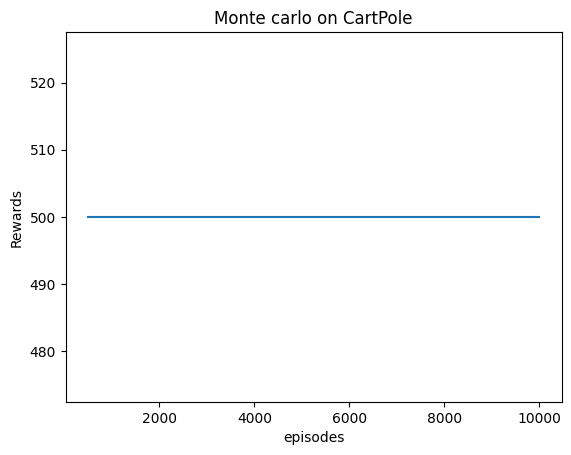

In [11]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
mc_cartpole = MonteCarlo(env, "CartPole", cartpole_discretizer, eps=0.1)
mc_cartpole.execute(total_ep=10000, eval_freq=500, eval_ep=500) # This will draw the reward vs. training reward plot

Reward on this episode 500.0


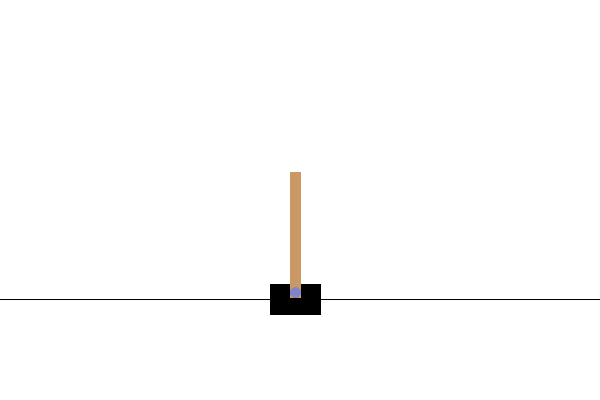

In [12]:
mc_cartpole.visualize()

In [13]:
mc_cartpole.eval(10)

500.0

Q function dimensions for MountainCar: (12, 15, 3)


100%|██████████| 2000/2000 [01:16<00:00, 26.01it/s]


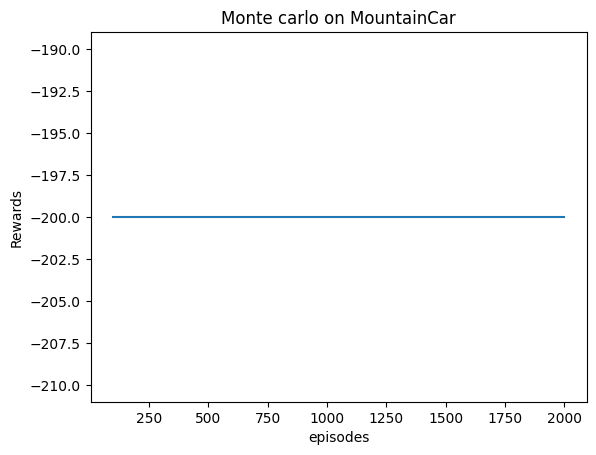

In [16]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
mc_mountaincar = MonteCarlo(env, "MountainCar", mountaincar_discretizer, eps=0.4)
mc_mountaincar.execute(total_ep=2000, eval_freq=100, eval_ep=100) # This will draw the plot

Reward on this episode -200.0


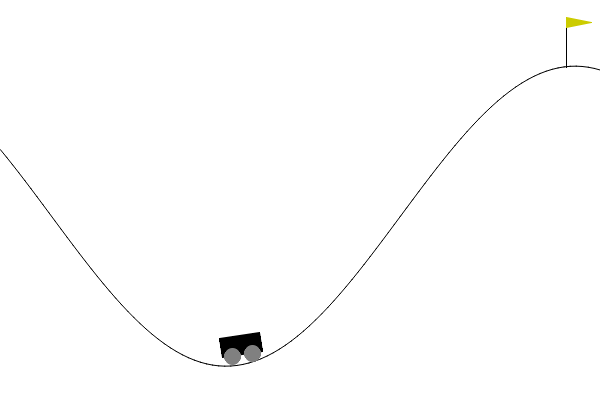

In [34]:
mc_mountaincar.visualize()

In [18]:
mc_mountaincar.eval(10)

-200.0

##Q-Learning

In [19]:
import numpy as np

class QLearning():
    def __init__(
        self,
        env,
        env_name,
        discretizer,
        eps=0.1
    ):
        self.env = env                                       # set env
        self.env_name = env_name                             # set env name
        self.eps = eps                                       # epsilon for epsion greedy
        self.mode = "update"                                 # mode to switch between update and evaluation of policy
        self.gif_maker = GIFMaker()                          # for visualizeation

        self.discretizer = discretizer                                # discretizer used to dicretize the observation
        self.state_dim = self.discretizer.num_states_each_dim         # get dimensions of discretized obersvation from helper
        self.action_dim = self.discretizer.num_actions                # get num of actions from helper

        self.q_dim = tuple(self.state_dim) + (self.action_dim,)              # q function dimenstion is state_dim x action_dim
        self.q = np.zeros(self.q_dim)                     # initialize q function, an nparray in the shape of self.q_dim
        self.counter = np.zeros(self.q_dim)               # counter used to track number of updates a particular index in q function, will be used in averaging returns
                                      # an nparray in the shape of self.q_dim, initialized by all zeros
        self.policy = np.ones(self.q_dim) / self.action_dim              # inital policy is uniform distribution, an nparray in the shape of self.q_dim.
                                      # the last dimension (which corresponding to all actions) should have sum=1 (representing probability)
        self.visited_states = []        # history of visited states.

        print(f"Q function dimensions for {env_name}: {self.q_dim}")



    # used to visite next state
    def visit_next_state(self, state):
        discretized_state = self.discretizer.discretize(state)                      # converts the current state to discrete
        self.visited_states.append(discretized_state)                               # puts the discretized state in the visited state history
        p = self.policy[tuple(discretized_state)]
        if self.mode == "update":
            action = np.random.choice(self.action_dim, p=p)                         # selects action based on current policy
        elif self.mode == "eval" or self.mode == "vis":
            action = np.argmax(p)                                                   # picks best action according to p

        next_state, reward, terminated, truncated, info = self.env.step(action)     # takes the selected action and move to next state

        if self.mode == "vis":
            self.g.append(self.env.render())                                        # render if visualization

        if terminated or truncated:
            return reward   # if terminated return current reward
        else:
            future_reward = self.visit_next_state(next_state)# call visit next state recursively to continue episode and get cumulative future reward
            immidiate_reward = reward         # save immidiate reward
            reward = reward + future_reward      # reward for current state action is immediate reward + cumulative future reward
            index_q = tuple(discretized_state)+(action,)     # index into q function, according to state and action
            index_q_prime = tuple(self.discretizer.discretize(next_state))      # get index of next state
            q_prime_max = np.max(self.q[index_q_prime])                         # get max_a(Q(s', a))
            self.counter[index_q] += 1    # increment state action counter, this is used for calculating the mean

            if self.mode == "update":
                self.q[index_q] = self.q[index_q] + (immidiate_reward + q_prime_max - self.q[index_q]) # update the q value of state based on the formula Q(s,a)=Q(s,a)+alpha(rewards+gamma(max_aQ(s', a))-Q(s,a))

            return reward # return the cumulative reward corresponding to "state"

    # update policy based on new q function
    def update_policy(self):
        vs = self.visited_states
        for s in vs: # for each state in an episode
          best_action = np.argmax(self.q[tuple(s)]) # get the best action for state from q
          # print ("state", best_action)
          self.policy[tuple(s)] = 0  # Reset policy for the state
          for i in range(self.action_dim): # go through each action in a set and use epsilon greedy to assign probabilities
              if(i == best_action):
                  self.policy[tuple(s) + (best_action, )] = (1-self.eps) + (self.eps/self.action_dim) # update policy with best action
              else:
                  self.policy[tuple(s) + (i, )] = self.eps/self.action_dim # update policy of not best action


    # run for one episode
    def run_one_episode(self):
        state, info = self.env.reset()
        r = self.visit_next_state(state)
        return r

    #policy update
    def update(self):
        self.mode = "update"
        self.observation, self.info = self.env.reset()
        r = self.run_one_episode()         # run one episode, update q function
        self.update_policy()               # update policy
        self.visited_states = []

    #policy evaluation for n episodes
    def eval(self, n):
        rewards = []
        self.mode = "eval"
        state, info = self.env.reset(seed=42)
        for i in range(n):
            r = self.run_one_episode()            # run one episode and get reward
            rewards.append(r)
        return np.mean(rewards)                   # return avergae reward over n episode

    #used for visualization
    def visualize(self):
        r = 0
        self.mode = "vis"
        self.g = GIFMaker()
        r = r + self.run_one_episode()
        print("Reward on vis episode", r)
        if self.env_name != "tic_tac":
            self.g.display()

    #the main fucntion called to update policy and evaluate for niter of outer iterations
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   #used to track polciy evaluation across runs
        episodes = []  #number of episodes used to update policy

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.update()                      # update
            if (i+1) % eval_freq == 0:      # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                rewards.append(reward)
                episodes.append(i)
        # print (episodes, rewards)
        plt.plot(episodes, rewards)   # plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('Q Learning on '+self.env_name)
        plt.show()


Q function dimensions for CartPole: (5, 10, 5, 10, 2)


100%|██████████| 10000/10000 [01:13<00:00, 135.30it/s]


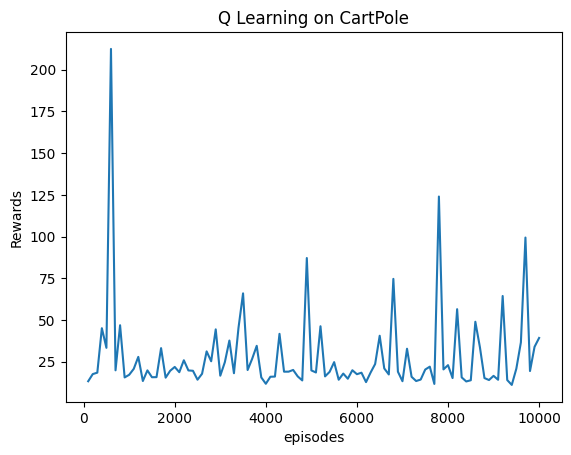

In [26]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
ql_cartpole = QLearning(env, "CartPole", cartpole_discretizer, eps=0.1)
ql_cartpole.execute(total_ep=10000, eval_freq=100, eval_ep=100) # This will draw the plot

Reward on vis episode 241.0


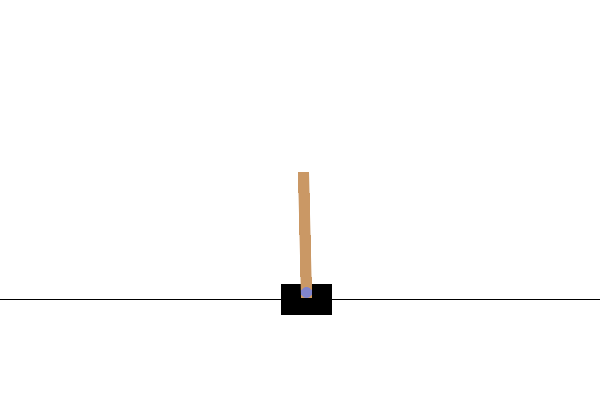

In [27]:
ql_cartpole.visualize()

In [31]:
ql_cartpole.eval(10)

26.6

Q function dimensions for MountainCar: (12, 15, 3)


100%|██████████| 2000/2000 [01:41<00:00, 19.69it/s]


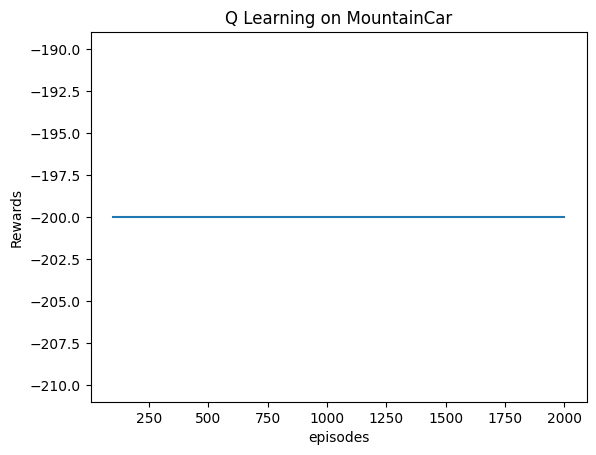

In [29]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
ql_mountaincar = QLearning(env, "MountainCar", mountaincar_discretizer, eps=0.1)
ql_mountaincar.execute(total_ep=2000, eval_freq=100, eval_ep=100) # This will draw the plot

Reward on vis episode -200.0


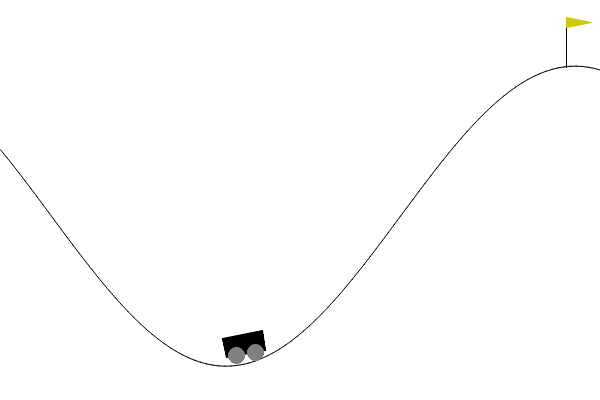

In [30]:
ql_mountaincar.visualize()

In [32]:
ql_mountaincar.eval(10)

-200.0